INFO     [covid19_npis.data] Loaded data for Germany.
INFO     [covid19_npis.data] Loaded data for Finland.


tf.Tensor(
[[[ 428.7343   428.7629   428.62906  427.56668]
  [ 389.77786  389.78857  389.77298  389.72522]]

 [[ 558.8564   558.90594  558.69037  556.99054]
  [ 492.52863  492.56973  492.53104  492.45288]]

 [[ 728.30316  728.3924   728.06     725.47424]
  [ 621.221    621.3667   621.25854  621.12726]]

 [[ 948.56366  948.74493  948.23956  944.4325 ]
  [ 779.7148   780.2122   779.88464  779.6409 ]]

 [[1233.4878  1233.9259  1233.1421  1227.657  ]
  [ 966.4561   968.0868   967.0683   966.5458 ]]], shape=(5, 2, 4), dtype=float32)


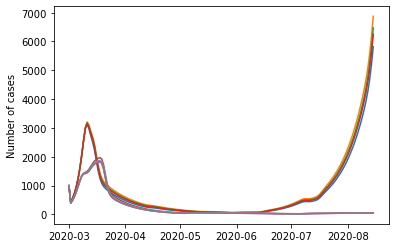

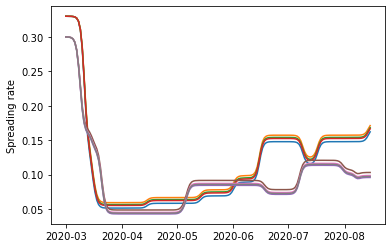

In [1]:
import sys
import logging
import time
import itertools
import os
import datetime
import functools

from tqdm import tqdm
import pandas as pd
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

sys.path.append("../../")
import covid19_npis
from covid19_npis.model import *


# Load data, it uses only the intervention data (when and which interventions were implemented)
# saved in interventions.csv in the respective country folder
# The length of the modelling is defined by the length of the files inside the country folders, 
# currently they are from the 2.3.2020 until the 15.8.2020
countries = [
    "Germany",
    "Finland",
]
c = [
    covid19_npis.data.Country(f"../../data/coverage_db/{country}",)
    for country in countries
]

# Construct our modelParams from the data.
modelParams = covid19_npis.ModelParams(countries=c, minimal_daily_deaths=0, offset_sim_data=1)



# Define the model
@pm.model()
def SIR_model(modelParams):
    lambda_0 = yield construct_lambda_0(
        name="lambda_0_c",
        modelParams=modelParams,
        loc=0.4,
        scale=0.1,
        hn_scale=0.05,  # Scale parameter of HalfNormal for each country
    )
    lambda_t = yield construct_R_t(
        name="lambda_t", modelParams=modelParams, R_0=lambda_0, include_noise = False
    )
    
    
    I_0_estimate = tf.reduce_mean(modelParams.pos_tests_data_tensor[1:6], axis=0)/0.6
    I_0 = (yield Normal(
        name="I_0_raw",
        loc = 0,
        scale=1,
        conditionally_independent=True,
        event_stack=(modelParams.num_countries, modelParams.num_age_groups),
    ))*I_0_estimate/6 + I_0_estimate
    I_0 = tf.math.softplus(I_0)
    log.debug(f"I_0:\n{I_0}")

    
    I_0 = yield Deterministic(
        name="I_0", value=I_0, shape_label=("country", "age_group"),
    )
        

    C = tf.constant(np.stack(
        np.array(
            [
                [
                    [1, 0.1, 0.1, 0.1],
                    [0.1, 1, 0.1, 0.1],
                    [0.1, 0.1, 1, 0.1],
                    [0.1, 0.1, 0.1, 1],
                ]
            ]
            * 2
        )
    ), dtype = I_0.dtype)
    log.debug(f"C:\n{C.shape}")
    log.debug(f"C:\n{C}")
    N = modelParams.N_data_tensor
    log.debug(f"N:\n{N}")
    new_I_t = InfectionModel_SIR(
        N=N,  I_0=I_0, lambda_t=lambda_t, C=C  
    )
    log.debug(f"new_I_t:\n{new_I_t[0,:]}")  # dimensons=t,c,a
    
    # Assume infections are positive tests
    positive_tests = yield Deterministic(
        name="positive_tests", value=new_I_t, shape_label=("time", "country", "age_group"),
    )
    
    
    yield covid19_npis.model.likelihood._studentT_positive_tests(modelParams, pos_tests=positive_tests)
    

# Define parameters for the test data set 
# These are defined not on the highest level, the sampling occurs on an unbounded space and
# some variables (for example alpha_i_c_a) depend on previous hierarchical variables. This allows
# to not define too many variables and nevertheless still get a test dataset.
params = {
    # population size per country and age group
    "N": np.array([[1e15, 1e15, 1e15, 1e15], [1e15, 1e15, 1e15, 1e15]]),
    # Reproduction number at t=0 per country and age group
    "lambda_0_c": np.array([0.33, 0.30]),
    # Initial infected
    "I_0": 1000 * np.array([[1, 1, 1, 1], [1, 1, 1, 1]]),
    # Change point date/index
    "delta_d_i": np.zeros((modelParams.num_interventions, 1, 1)),
    "delta_d_c": np.zeros((1, modelParams.num_countries, 1)),
    "sigma_d_interv": 0.3,
    "sigma_d_country": 0.3,
    # Length of the change point
    "l_i_sign": 4 * np.ones((modelParams.num_interventions,)),
    # Alpha value of the change point
    "alpha_i_c_a": np.stack(
        [[[0.78, 0.72, 0.74, 0.75], [0.78, 0.73, 0.76, 0.77]]]
        * modelParams.num_interventions
    )
    * 0.65,
    "C": np.stack(
        np.array(
            [
                [
                    [1, 0.1, 0.1, 0.1],
                    [0.1, 1, 0.1, 0.1],
                    [0.1, 0.1, 1, 0.1],
                    [0.1, 0.1, 0.1, 1],
                ]
            ]
            * 2
        )
    ),
}

# Create the test data
(
    positive_tests,
    lambda_t,
), trace = covid19_npis.test_data.data_generators.test_data_from_model(
    SIR_model,
    modelParams,
    params,
    [
        "positive_tests",
        "lambda_t",]
)


# Plot the data set for the test. 
# The first point is the total infection pool and not the new infections, that's why it is larger than the rest
plt.plot(positive_tests)
plt.ylabel("Number of cases")
plt.figure()
plt.plot(lambda_t)
plt.ylabel("Spreading rate")

# Set the test data set 
modelParams._dataframe_new_cases = positive_tests[1:] 
modelParams.pos_tests_data_tensor = positive_tests[1:]
positive_tests_formatted = modelParams.pos_tests_data_tensor[1:]
modelParams._set_data_mask()
this_model = SIR_model(modelParams) 

print(modelParams.pos_tests_data_tensor[1:6])



Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


WARNING  [tensorflow] From /home/jdehning/miniconda3/envs/python38/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:5043: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Runtime: 158.983 s
Likelihood: 3919.06787109375


INFO     [covid19_npis.model.distributions] running time: 163.0s


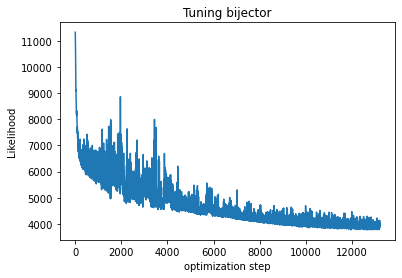

INFO     [covid19_npis.model.distributions] start
Auto-assigning NUTS sampler
INFO     [pymc4.sampling] Auto-assigning NUTS sampler
INFO     [pymc4.inference.sampling] Begin tuning
tuning windows: [ 100  150  250  350  550  800 1150]
INFO     [pymc4.sampling] tuning windows: [ 100  150  250  350  550  800 1150]
log-like: -3500.2: 100%|██████████| 3350/3350 [04:19<00:00, 12.92it/s]
INFO     [pymc4.inference.sampling] Begin sampling
log-like: -3497.6: 100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s]
INFO     [covid19_npis.model.distributions] running time: 454.8s


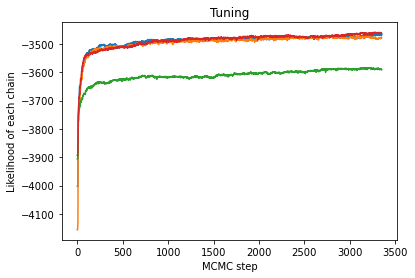

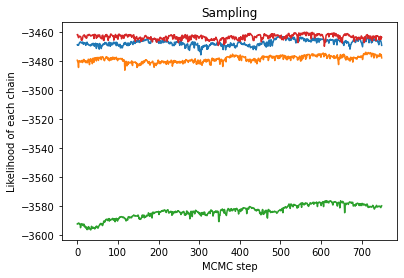

In [2]:
# Some checks
def print_dist_shapes(st):
    for name, dist in itertools.chain(
        st.discrete_distributions.items(), st.continuous_distributions.items(),
    ):
        if dist.log_prob(st.all_values[name]).shape != (5,):
            log.warning(
                f"False shape: {dist.log_prob(st.all_values[name]).shape}, {name}"
            )
    for p in st.potentials:
        if p.value.shape != (5,):
            log.warning(f"False shape: {p.value.shape} {p.name}")


_, sample_state = pm.evaluate_model_transformed(this_model, sample_shape=(5,))
print_dist_shapes(sample_state)


"""  # 2. MCMC Sampling
"""
num_chains = 4
use_VI = True
jit_compile = True

if use_VI:
    begin_time = time.time()
    from tensorflow_probability import distributions as tfd
    from tensorflow_probability import bijectors as tfb
    
    
    _, state = pm.evaluate_model_transformed(this_model)
    state, _ = state.as_sampling_state()

    """
    Retrieve the name of all transformed distributions 
    """
    values_dict = dict(state.all_unobserved_values)
    transformed_names = list(values_dict.keys())


    """
    Construct joined distribution from a sample of all prior distributions. 
    (not taking noise into respect)
    # Note: Does this correspond to the variational parameters Phi, in the sticking the landing paper?
    """
    # Note: Why Normal distribution as base? Shouldn't that depend on the underlying distribution?
    normal_base = tfd.JointDistributionNamed(
        {
            name: tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=tensor.shape)
            for name, tensor in values_dict.items()
        },
        validate_args=False,
        name="normal_base",
    )

    # Note: What is this abomination? Can we apply some make-up please?
    order_list = ["left-to-right", "right-to-left", "left-to-right"]

    bijector = covid19_npis.model.build_iaf(values_dict, order_list)

    """We transform our joined distribution with the previously created bijector.
    """
    posterior_approx = tfd.TransformedDistribution(normal_base, bijector=bijector)

    sample_size = 4

    (
        logpfn,
        init_random,
        _deterministics_callback,
        deterministic_names,
        state_,
    ) = pm.mcmc.samplers.build_logp_and_deterministic_functions(
        this_model, num_chains=sample_size, collect_reduced_log_prob=False
    )

    trace_loss = lambda traceable_quantities: tf.debugging.check_numerics(
        traceable_quantities.loss, f"loss not finite: {traceable_quantities.loss}"
    )

    # For eventual debugging:
    # tf.config.run_functions_eagerly(True)
    # tf.debugging.enable_check_numerics(stack_height_limit=50, path_length_limit=50)

    begin = time.time()
        
    if jit_compile:
        # Run the entire minimization inside a jit-compiled function. 
        @tf.function(autograph=False, experimental_compile=True)
        def fit_surrogate_posterior(*args, **kwargs):
            return tfp.vi.fit_surrogate_posterior(*args, **kwargs)
    else: 
        fit_surrogate_posterior = tfp.vi.fit_surrogate_posterior
    
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=5_000,
    decay_rate=0.1,
    staircase=False)

    
    loss_arr = fit_surrogate_posterior(
        logpfn,
        posterior_approx,
        tf.optimizers.Adam(
            learning_rate=lr_schedule, epsilon=1e-7, beta_1=0.9, beta_2=0.999, clipvalue=10.0
        ),
        100_000,
        convergence_criterion=tfp.optimizer.convergence_criteria.LossNotDecreasing(
            atol=0.02, rtol=None, window_size=2_000, min_num_steps=10_000),
        sample_size=sample_size,
        trainable_variables=None,
        #jit_compile=True,
        variational_loss_fn=functools.partial(
            tfp.vi.monte_carlo_variational_loss,
            discrepancy_fn=tfp.vi.kl_reverse,
            use_reparameterization=True,
        ),
        trace_fn=trace_loss,
    )
    loss_arr = loss_arr[np.array(loss_arr!=loss_arr[-1])]
    log.info(f"Likelihood: {np.mean(loss_arr[-1000:])}")

    _, st = pm.evaluate_model_posterior_predictive(
        this_model, values=posterior_approx.sample(100)
    )
    var_names = list(st.all_values.keys()) + list(st.deterministics_values.keys())
    samples = {
        k: (
            st.untransformed_values[k]
            if k in st.untransformed_values
            else (
                st.deterministics_values[k]
                if k in st.deterministics_values
                else st.transformed_values[k]
            )
        )
        for k in var_names
    }


    init_state = posterior_approx.sample(num_chains)
    init_state = [init_state[name] for name in transformed_names]
    bijector_to_list = tfb.Restructure(
        [name for name in transformed_names], {name: name for name in transformed_names}
    )
    bijector_list = tfb.Chain(
        [bijector_to_list, bijector, tfb.Invert(bijector_to_list)]
    )
    end_time = time.time()
    log.info("running time: {:.1f}s".format(end_time - begin_time))

    plt.figure()
    plt.plot(loss_arr)
    plt.title("Tuning bijector")
    plt.ylabel('Likelihood')
    plt.xlabel('optimization step')
    plt.show()
    
else:
    bijector_list = None
    init_state = None


# Begin sampling
begin_time = time.time()
log.info("start")



trace_tuning, trace = pm.sample(
    this_model,
    num_samples=1000,
    num_samples_binning=50,
    burn_in_min=100,
    burn_in=2000,
    use_auto_batching=False,
    num_chains=num_chains,
    xla=True,
    initial_step_size=0.0001,
    ratio_tuning_epochs=1.5,
    max_tree_depth=4,
    decay_rate=0.75,
    target_accept_prob=0.75,
    step_size_adaption_per_chain=False,
    bijector=bijector_list,
    init_state=init_state,
)

end_time = time.time()
log.info("running time: {:.1f}s".format(end_time - begin_time))


plt.figure()
plt.plot(trace_tuning.sample_stats["lp"].T)
plt.title("Tuning")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()

plt.figure()
plt.plot(trace.sample_stats["lp"].T)
plt.title("Sampling")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()




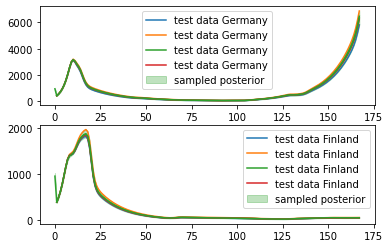

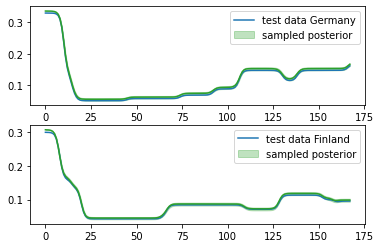

In [3]:
f, axes = plt.subplots(2)
positive_tests_formatted = modelParams.pos_tests_data_tensor[:]

x = np.arange(len(positive_tests))
axes[0].plot(np.array(positive_tests_formatted)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(positive_tests_formatted)[:,1], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


f, axes = plt.subplots(2)
x = np.arange(len(positive_tests))
axes[0].plot(np.array(lambda_t)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(lambda_t)[:,4], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


In [ ]:
plt.plot(trace_tuning.posterior["SIR_model|delta_lambda_0_c"][:,:100,1].T)
plt.figure()
plt.plot(trace_tuning.posterior["SIR_model|delta_lambda_0_c"][:,:100,0].T)

In [ ]:
plt.plot(trace_tuning.posterior["SIR_model|lambda_0_sigma_c"][:,:100].T)

In [ ]:
plt.plot(trace_tuning.posterior["SIR_model|positive_tests"][:,:100,25,1,1].T)
plt.figure()
plt.plot(trace_tuning.posterior["SIR_model|sigma_likelihood_pos_tests"][:,:200,1].T)

In [ ]:
i=30
plt.plot(np.array(positive_tests_formatted)[:,1], label='test data Finland')
plt.plot(trace_tuning.posterior['SIR_model|positive_tests'][1,i,:,1,:],color='tab:green')
plt.figure()
plt.plot(np.array(lambda_t)[:,4], label='test data Finland')
plt.plot(trace_tuning.posterior['SIR_model|lambda_t'][1,i,...,1,:],color='tab:green')

In [ ]:
modelParams.data_stratified_mask

In [ ]:
trace.posterior

## Building a likelihood for other programs 

In [ ]:
# Build likelihood function and a random initialization (from the prior)

from pymc4.mcmc.samplers import build_logp_and_deterministic_functions
(logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                                    this_model,
                                    collect_reduced_log_prob=False,)

# random_init is a dictionary with all values needed to calculate the likelihood. 
# logpfn requires the unbounded variables (as saved in random_init). 
# They can be passed either as dictionary or as list:
print(f"likelihood (of random init): {logpfn(**random_init)}")
print(f"likelihood (of random init): {logpfn(*list(random_init.values()))}")

### To get the number of cases and the lambda_t from a choice of parameters:


In [ ]:

# Build a dummy trace, which requires extra chain and draw dimensions
dict_for_dummy_trace = {key:tf.cast(value, "float32")[tf.newaxis, tf.newaxis] 
                        for key,value in random_init.items()}
trace_tmp = az.from_dict(posterior=dict_for_dummy_trace)


variables = ["lambda_t", "positive_tests"]
model_name = "SIR_model"
var_names = []
for var in variables:
    var_names.append(f"{model_name}|{var}")

# And sample it from the model. It will use the variables saved in trace_tmp, if there is one variable
# not defined, it is randomly chosen from its distribution. 
trace_res = pm.sample_posterior_predictive(
    SIR_model(modelParams), trace_tmp, var_names=var_names, use_auto_batching=False,
)

# And plot the resulting spreading rate, it is saved in trace_res.posterior_predictive 
plt.plot(trace_res.posterior_predictive["SIR_model|lambda_t"][0,0,:,1,0])
plt.ylabel("spreading rate of random initialization")

In [ ]:
sample_state.transformed_values.keys()

In [ ]:
trace_tuning.sample_stats['SIR_model|tree_size']

In [ ]:
random_inits = []
n_inits = 20
for i in range(n_inits):
    (logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                                    this_model,
                                    collect_reduced_log_prob=False,num_chains =100)
    random_inits.append(random_init)

for 
    
logpfn(**random_inits[-1])
begin_time = time.time()
for random_init in random_inits:
    a = logpfn(**random_init)

end_time = time.time()
log.info("running time: {:.1f}ms".format((end_time - begin_time)*1000/n_inits))

In [ ]:
from pymc4.mcmc.utils import initialize_sampling_state
from pymc4.mcmc.samplers import tile_init
nchains = 1
niter = 50

def merge_init(init_states):
    init = []
    for i in range(len(init_states[0])):
        init.append(tf.stack([init_state[i] for init_state in init_states]))
    return init

inits = []

for i in range(niter):
    init_chains = []
    for j in range(nchains):
        state, deterministic_names = initialize_sampling_state(this_model)
        init = dict(state.all_unobserved_values)
        init_state = list(init.values())
        init_chains.append(init_state)
    init_state = merge_init(init_chains)
    inits.append(init_state)

(logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                            this_model,
                            collect_reduced_log_prob=False,num_chains =nchains)
    
logpfn(*inits[-1])
begin_time = time.time()
for init in inits:
    a = logpfn(*init)
end_time = time.time()
log.info("running time: {:.1f}ms".format((end_time - begin_time)*1000/nchains/niter))
    

In [ ]:
n_eval = np.sum(trace.sample_stats['tree_size']+1) + np.sum(trace.sample_stats['tree_size']+1)

In [ ]:
n_eval

In [ ]:
@tf.function(experimental_compile=True)
def InfectionModel_SIR_test(N, I_0, C, T, recov_rate=1 / 8, h_t=None):
    r"""
    This function combines a variety of different steps:

        #. Converts the given :math:`E_0` values  to an exponential distributed initial :math:`E_{0_t}` with an
           length of :math:`l` this can be seen in :py:func:`_construct_E_0_t`.

        #. Calculates :math:`R_{eff}` for each time step using the given contact matrix :math:`C`:

            .. math::
                R_{diag} &= \text{diag}(\sqrt{R}) \\
                R_{eff}  &= R_{diag} \cdot C \cdot R_{diag}

        #. Calculates the :math:`\tilde{I}` arrays i.e. new infectious for each age group and
           country, with the efficient reproduction matrix :math:`R_{eff}`, the susceptible pool
           :math:`S`, the population size :math:`N` and the generation interval :math:`g(\tau)`.
           This is done recursive for every time step.

            .. math::
                    \tilde{I}(t) &= \frac{S(t)}{N} \cdot R_{eff} \cdot \sum_{\tau=0}^{t} \tilde{I}(t-1-\tau) g(\tau) \\
                    S(t) &= S(t-1) - \tilde{I}(t-1)

    Parameters
    ----------
    N:
        Total population per country
        |shape| country, age_group
    I_0_t:
        Initial number of infectious.
        |shape| batch_dims, country, age_group
    lambda_t:
        spreading rate matrix.
        |shape| time, batch_dims, country, age_group

    C:
        inter-age-group Contact-Matrix (see 8)
        |shape| country, age_group, age_group
    recov_rate:
        recovery rate
        |shape| batch_dims, country, age_group
    h_t:
        eventual external input
        |shape| time, batch_dims, country, age_group
    Returns
    -------
    :
        Sample from distribution of new, daily cases
    """

    # @tf.function(autograph=False)

    # For robustness of inference
    # R_t = tf.clip_by_value(R_t, 0.5, 7)
    # R_t = tf.clip_by_norm(R_t, 100, axes=0)
    
    with tf.GradientTape() as tape:
        lambda_ = tf.ones_like(I_0)*recov_rate + 0.00001

        def loop_body(params, elems):
            # Unpack a:
            # Old E_next is E_lastv now
            h = elems
            _, I_last, S_t = params  # Internal state

            # Internal state
            f = S_t / N

            # log.debug(f"I_t {I_t}")

            # Calculate effective lambda_t [country,age_group] from Contact-Matrix C [country,age_group,age_group]
            lambda_sqrt = tf.math.sqrt(lambda_ + 1e-7)
            lambda_diag = tf.linalg.diag(lambda_sqrt)
            lambda_eff = tf.einsum(
                "...ij,...ik,...kl->...il", lambda_diag, C, lambda_diag
            )  # Effective growth number

            # log.debug(f"infectious: {infectious}")
            # log.debug(f"R_eff:\n{R_eff}")
            # log.debug(f"f:\n{f}")
            # log.debug(f"h:\n{h}")

            # Calculate new infections
            infections = tf.einsum("...ci,...cij,...cj->...cj", I_last, lambda_eff, f) + h
            infections = tf.clip_by_value(infections, 0.01, 1e9)  # for robustness

            # Calculate new infectious pool
            I_new = infections + I_last - recov_rate * I_last

            return infections, I_new, S_t

        # Number of days that we look into the past for our convolution

        S_initial = N - I_0

        len_added = 1

        lambda_t_for_loop = lambda_t[len_added:]
        if not h_t:
            h_t_for_loop = tf.zeros([T] + list(I_0.shape))
        else:
            h_t_for_loop = h_t[len_added:]
        # Initial susceptible population = total - infected

        """ Calculate time evolution of new, daily infections
            as well as time evolution of susceptibles
            as lists
        """

        initial = (
            tf.zeros_like(S_initial),
            I_0,
            S_initial,
        )
        out = tf.scan(
            fn=loop_body, elems=(h_t_for_loop), initializer=initial
        )
        daily_infections_final = out[0]
        daily_infections_final = tf.concat(
            [I_0[tf.newaxis, ...], daily_infections_final], axis=0
        )

        # Transpose tensor in order to have batch dim before time dim
        daily_infections_final = tf.einsum("t...ca->...tca", daily_infections_final)

        log.debug(f"daily_infections_final:\n{daily_infections_final}")
        log.debug(
            f"daily_infections_final sum:\n{tf.reduce_sum(daily_infections_final, axis=-3)}"
        )
        daily_infections_final = tf.clip_by_value(daily_infections_final, 1e-6, 1e6)

    return tape.gradient(daily_infections_final, [I_0,C])
    #return tf.gradients(daily_infections_final, [I_0, C])
    #return daily_infections_final


niter = 50
n_countries = 20
N = tf.ones((n_countries,1))*1e15
I_0 = tf.ones((n_countries,1))*20.
C = tf.ones((1,1))
T = 400
I_0 = tf.Variable(I_0)
C = tf.Variable(C)
InfectionModel_SIR_test(N, I_0, C, T)
begin_time = time.time()
for i in range(niter):
    I_0_rand = I_0 + tf.random.normal([])
    a = InfectionModel_SIR_test(N, I_0_rand, C, T)
end_time = time.time()  
print(a)
log.info("running time: {:.3f}ms".format((end_time - begin_time)*1000/niter/T*170/n_countries*2))